In [58]:
import pandas as pd
import numpy as np
import gutenbergpy.textget
import re
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
from plotnine import *

In [ ]:
book_authors = {
    'Charles Dickens': [46, 98, 1400, 730, 766, 1023, 786, 580, 883],
    'Herman Melville': [2701, 11231, 15859, 21816, 34970, 10712, 12384, 4045, 8118, 2694, 13720, 53861],
    'Jane Austen': [1342, 158, 161, 105, 121, 141, 946]
}

In [ ]:
book_contents = {}
for book_id in [book_id for id_list in book_authors.values() for book_id in id_list]:
    # Load in the book
    raw_book = gutenbergpy.textget.get_text_by_id(book_id)
    clean_book = gutenbergpy.textget.strip_headers(raw_book)
    # Convert to string
    book = clean_book.decode('UTF-8')
    # Remove first characters of the book (remove chapter headings, etc)
    #book = book[10000:]
    book_contents[book_id] = book


In [21]:
books_wtoks = {}
books_stoks = {}
for book_id, book in book_contents.items():
    books_wtoks[book_id] = word_tokenize(book)
    books_stoks[book_id] = sent_tokenize(book)

In [34]:
book_stats = {}
for book_id in book_contents.keys():
    book_stats[book_id] = {}
    book_stok = books_stoks[book_id]
    book_wtok = books_wtoks[book_id]
    (book_stats[book_id])['sent_chars'] = [len(sent) for sent in book_stok]
    (book_stats[book_id])['sent_words'] = [len(word_tokenize(sent)) for sent in book_stok]
    (book_stats[book_id])['word_chars'] = [len(word) for word in book_wtok]

In [74]:
# Plot the distributions by book
word_chars = {book_id:book_stat['word_chars'] for book_id, book_stat in book_stats.items()}

3.8702941176470587


In [97]:
book_authors_df = pd.melt(pd.DataFrame.from_dict({k:pd.Series(v) for k, v in book_authors.items()}))
book_authors_df.columns = ['author_name', 'book_id']
df = 
pd.melt(book_authors_df)
df.join(book_authors)

,variable,value
0,Charles Dickens,46.0
1,Charles Dickens,98.0
2,Charles Dickens,1400.0
3,Charles Dickens,730.0
4,Charles Dickens,766.0
5,Charles Dickens,1023.0
6,Charles Dickens,786.0
7,Charles Dickens,580.0
8,Charles Dickens,883.0
9,Charles Dickens,NaN


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_boxplot : Removed 7783634 rows containing non-finite values.


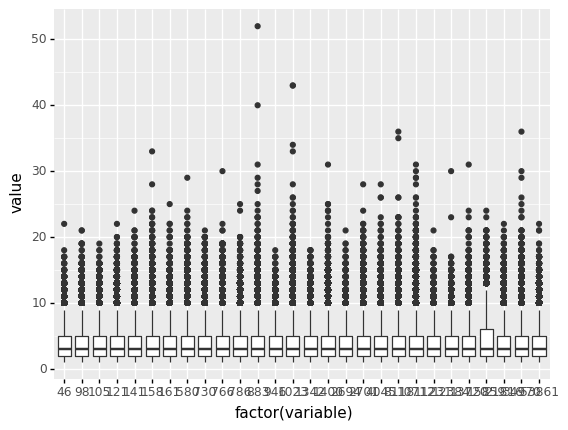

<ggplot: (124919975201)>

In [93]:
word_chars_df = pd.DataFrame.from_dict({k: pd.Series(v) for k, v in word_chars.items()}, orient='columns')
word_chars_df_long = pd.melt(word_chars_df).dropna(how='any')
book_authors_df = pd.DataFrame.from_dict
word_chars_df_long = pd.join

(
    ggplot(word_chars_df_long)
    + geom_boxplot(aes(x='factor(variable)', y='value'))
)

In [90]:
pd.melt(df)

,variable,value
0,46,1.0
1,46,9.0
2,46,5.0
3,46,2.0
4,46,5.0
...,...,...
12421215,946,NaN
12421216,946,NaN
12421217,946,NaN
12421218,946,NaN


In [ ]:
sorted(grams)[0:10]

In [ ]:
list(grams)
new_grams = grams.copy()
gram_count = {}
for i in range(0, len(grams)-1):
    gram = new_grams.pop(0)
    if gram in new_grams:
        if gram not in gram_count:
            gram_count[gram] = 0
        gram_count[gram] += 1

In [ ]:
dict(sorted(gram_count.items(), key=lambda item: -item[1]))